1차 업로드 도면 수: 10
2차 업로드 도면 수: 6


도면 매칭 중: 100%|████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.95s/it]


매칭 완료 및 CSV 저장: ./out/matched_pairs.csv


변경 탐지 중: 100%|████████████████████████████████████████████████████████████████████| 10/10 [00:10<00:00,  1.00s/it]


변경 탐지 완료 및 요약 저장: ./out/diff_summary.csv


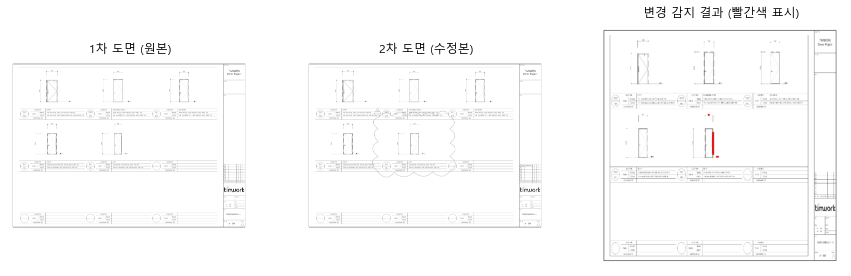

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.metrics import structural_similarity as ssim  # 이미지 유사도 계산용
from tqdm import tqdm  # 진행률 표시
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'Malgun Gothic'  # 한글 깨짐 방지
matplotlib.rcParams['axes.unicode_minus'] = False


# 경로 설정
# DIR_V1 : 1차 업로드된 원본 도면
# DIR_V2 : 2차 업로드된 수정본
# DIR_OUT : 결과를 저장할 폴더

DIR_V1 = "./first_upload"
DIR_V2 = "./second_upload"
DIR_OUT = "./out"

# 결과 저장용 폴더가 없으면 자동으로 생성
os.makedirs(DIR_OUT, exist_ok=True)
os.makedirs(f"{DIR_OUT}/diff_overlay", exist_ok=True)  # 변경된 부분을 색으로 덧입힌 이미지


# 파일 불러오기
# .png 형식의 도면 이미지만 읽어옴
# os.listdir()로 폴더 내 파일을 읽고, 조건문으로 .png만 선택

v1_files = [os.path.join(DIR_V1, f) for f in os.listdir(DIR_V1) if f.endswith(".png")]
v2_files = [os.path.join(DIR_V2, f) for f in os.listdir(DIR_V2) if f.endswith(".png")]

print(f"1차 업로드 도면 수: {len(v1_files)}")
print(f"2차 업로드 도면 수: {len(v2_files)}")


# 도면 매칭 (SSIM)
# 1차 도면(v1) 하나당, 2차 도면(v2) 중에서 "가장 비슷한" 도면을 자동으로 찾아 짝을 맞춤

# SSIM(Structural Similarity Index)은 두 이미지의 구조적 유사도를 측정하는 방법
# 값이 1에 가까울수록 두 이미지가 거의 동일

# MSE로 단순히 픽셀 차이의 제곱 평균 계산하면
# 밝기 차이에도 민감해서 도면의 미세한 명암 변화에 오탐 많음

# 도면은 “밝기나 선 두께”보다 “형태와 구조”가 중요한 데이터이므로,
# 구조적 유사도를 평가하는 SSIM이 가장 효율적이고 실용적인 선택

# 회전, 이동에는 약함 → 그래서 코드에서 ECC(정합) 단계를 추가함

matches = []  # (v1, v2, ssim) 정보를 저장할 리스트

for v1_path in tqdm(v1_files, desc="도면 매칭 중"):
    # 1차 도면을 회색조로 읽고 크기를 1000x1000으로 맞춤
    # 크기를 맞추는 이유: SSIM 비교 시 해상도가 다르면 비교가 정확하지 않음.
    img1 = cv2.imread(v1_path, cv2.IMREAD_GRAYSCALE)
    img1 = cv2.resize(img1, (1000, 1000))

    best_score = -1      # 지금까지 찾은 최고 유사도
    best_match = None    # 최고 유사도를 가진 2차 도면 경로

    # 2차 도면들과 하나씩 비교하여 가장 높은 SSIM을 찾음
    for v2_path in v2_files:
        img2 = cv2.imread(v2_path, cv2.IMREAD_GRAYSCALE)
        img2 = cv2.resize(img2, (1000, 1000))

        score = ssim(img1, img2)  # 유사도 계산
        if score > best_score:
            best_score = score
            best_match = v2_path

    # 가장 유사한 쌍을 기록
    matches.append({"v1": v1_path, "v2": best_match, "ssim": best_score})

# 결과를 표로 정리하고 CSV 파일로 저장
df_match = pd.DataFrame(matches)
df_match.to_csv(f"{DIR_OUT}/matched_pairs.csv", index=False)
print("매칭 완료 및 CSV 저장:", f"{DIR_OUT}/matched_pairs.csv")


# 정합(Alignment) 및 변경 탐지
# 위에서 매칭된 도면 쌍을 기준으로 실제 변경된 부분을 찾아냄
# 두 도면이 약간 회전하거나 위치가 다를 수 있기 때문에
# ECC(Enhanced Correlation Coefficient) 정합 알고리즘으로 위치를 보정

results = []

for _, row in tqdm(df_match.iterrows(), total=len(df_match), desc="변경 탐지 중"):
    # 1차, 2차 도면을 동일 크기로 읽기
    img1 = cv2.imread(row.v1, cv2.IMREAD_GRAYSCALE)
    img1 = cv2.resize(img1, (1000, 1000))
    img2 = cv2.imread(row.v2, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.resize(img2, (1000, 1000))

    # ECC 정합 (두 이미지의 위치 차이를 자동 보정)
    warp_matrix = np.eye(2, 3, dtype=np.float32)
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 50, 1e-5)

    try:
        # img1을 기준으로 img2를 맞추기
        cc, warp_matrix = cv2.findTransformECC(img1, img2, warp_matrix, cv2.MOTION_EUCLIDEAN, criteria)
        img2_aligned = cv2.warpAffine(img2, warp_matrix, (img1.shape[1], img1.shape[0]), flags=cv2.INTER_LINEAR)
    except cv2.error:
        # 정합 실패 시 그냥 원본 그대로 사용
        img2_aligned = img2

    # 변경된 부분 찾기: 두 이미지를 픽셀 단위로 비교
    diff = cv2.absdiff(img1, img2_aligned)        # 두 이미지의 절대 차이
    _, mask = cv2.threshold(diff, 40, 255, cv2.THRESH_BINARY)  # 밝기 차이가 큰 부분만 추출
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))  # 작은 점(노이즈) 제거
    mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, np.ones((5,5), np.uint8))  # 변경 영역을 조금 확장

    # 시각화: 변경된 부분을 빨간색으로 표시
    overlay = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    overlay[mask > 0] = [0, 0, 255]  # 빨간색(RGB: [0,0,255])

    # 결과 저장 (mask 저장은 제거, overlay만 저장)
    base_name = os.path.basename(row.v1).replace(".png", "")
    cv2.imwrite(f"{DIR_OUT}/diff_overlay/{base_name}_overlay.png", overlay)

    # 전체 중 몇 %가 변경되었는지 계산
    change_ratio = (mask > 0).sum() / mask.size

    results.append({
        "v1": row.v1,
        "v2": row.v2,
        "ssim": row.ssim,
        "change_ratio": change_ratio
    })

# 모든 결과를 요약 CSV로 저장
df_result = pd.DataFrame(results)
df_result.to_csv(f"{DIR_OUT}/diff_summary.csv", index=False)
print("변경 탐지 완료 및 요약 저장:", f"{DIR_OUT}/diff_summary.csv")


# 샘플 시각화
# 결과를 눈으로 확인할 수 있도록 샘플 1개를 화면에 출력

sample = df_result.iloc[0]  # 첫 번째 결과를 선택
overlay_img = cv2.imread(f"{DIR_OUT}/diff_overlay/{os.path.basename(sample.v1).replace('.png','')}_overlay.png")

plt.figure(figsize=(15,5))

# 1차 도면
plt.subplot(1,3,1)
plt.imshow(cv2.imread(sample.v1, cv2.IMREAD_GRAYSCALE), cmap="gray")
plt.title("1차 도면 (원본)")
plt.axis("off")

# 2차 도면
plt.subplot(1,3,2)
plt.imshow(cv2.imread(sample.v2, cv2.IMREAD_GRAYSCALE), cmap="gray")
plt.title("2차 도면 (수정본)")
plt.axis("off")

# 변경 감지 결과 (빨간색 표시)
plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(overlay_img, cv2.COLOR_BGR2RGB))
plt.title("변경 감지 결과 (빨간색 표시)")
plt.axis("off")

plt.show()

# SIM을 사용한 이유
# 단순한 픽셀 차이보다 '구조적 유사도'를 이용하면 도면 매칭 정확도가 높음.

# ECC 정합 사용 이유
# 촬영 위치나 스캔 각도 차이로 생기는 오차를 자동으로 보정하기 위해.

# Morphology(형태학) 연산 사용 이유
# 작은 점이나 선 같은 노이즈를 제거하고, 실제 변경된 영역만 남기기 위해.

## out/ 폴더 개요

이 폴더는 도면 비교 결과물 전체가 저장되는 결과 저장소임  
즉, 이 안에는 “매칭 결과”, “변경 영역 이미지”, “요약 통계”가 모두 들어감

실행 후 구조는 아래처럼 구성됨

out/
├── matched_pairs.csv       ← (1) 도면 매칭 결과 테이블  
├── diff_summary.csv        ← (2) 변경 탐지 요약 테이블  
├── diff_overlay/           ← (3) 도면 위에 변경 부분 시각화한 이미지  

---

### matched_pairs.csv

**도면 매칭(1차 vs 2차)** 단계의 결과

| 컬럼 | 설명 |
|------|------|
| v1 | 1차 업로드 도면 파일 경로 |
| v2 | 해당 도면과 가장 유사한 2차 업로드 도면 경로 |
| ssim | 두 이미지 간 구조적 유사도 점수 (0~1, 1에 가까울수록 동일) |

**예시:**

| v1 | v2 | ssim |
|----|----|------|
| first_upload/92c5a0...png | second_upload/48a979...png | 0.985 |
| first_upload/a479fc...png | second_upload/4ff0f5...png | 0.912 |

이 파일을 보면, 어떤 도면이 어떤 도면과 짝을 이루는지 알 수 있음  
즉, “이 도면은 이 도면의 수정본이구나”를 정리한 표 느낌

---

### diff_summary.csv

**변경 탐지 결과 요약**

이 파일은 각 도면 쌍별 변경 분석 결과를 수치로 요약한 테이블 느낌

| 컬럼 | 설명 |
|------|------|
| v1 | 1차 업로드 도면 경로 |
| v2 | 짝지어진 2차 업로드 도면 경로 |
| ssim | 두 도면의 구조적 유사도 |
| change_ratio | 전체 픽셀 중 변경된 픽셀의 비율 (0~1) |

**예시:**

| v1 | v2 | ssim | change_ratio |
|----|----|------|--------------|
| first_upload/92c5a0...png | second_upload/48a97...png | 0.98 | 0.0021 |
| first_upload/aa9f13...png | second_upload/b9868...png | 0.89 | 0.0462 |

이 파일을 보면 “어떤 도면이 얼마나 많이 바뀌었는지” 한눈에 볼 수 있음  
예를 들어 `change_ratio`가 0.05 이상이면, 전체 도면 중 약 5% 이상이 바뀌었다는 뜻 느낌  
→ 변경이 큰 도면을 자동으로 선별할 때 유용함

---

### diff_overlay/

**도면 위에 변경 영역을 빨간색으로 오버레이한 이미지 느낌**

- 파일명 예시:  
  `diff_overlay/92c5a0..._overlay.png`

원본 도면(1차)을 배경으로 하고  
변경된 영역은 **빨간색 (RGB [255,0,0])** 으로 표시됨

**예시**  
회색 도면 위에 빨간색으로 “추가되거나 삭제된” 부분이 하이라이트된 이미지 느낌

이 파일을 열어보면  
“눈으로 바로 어디가 바뀌었는지” 한눈에 확인 가능함  
(보고서용, 현장 담당자 피드백용 활용 가능)

---

### 정리: 각 파일의 역할 요약표

| 폴더/파일 | 용도 | 주요 활용 |
|------------|------|------------|
| matched_pairs.csv | 도면 쌍 매칭 결과 | 어떤 도면끼리 비교되었는지 확인 느낌 |
| diff_summary.csv | 변경 탐지 요약 | 변경량 순 정렬, 변경 많은 도면 찾기 느낌 |
| diff_overlay/ | 도면 위 변경 시각화 | 결과 시각화 및 리포트용 이미지 느낌 |

---

### 결과 해석 예시

| 상황 | 해석 |
|------|------|
| `ssim ≈ 1.0`, `change_ratio ≈ 0.0` | 거의 동일한 도면 (수정 없음) 느낌 |
| `ssim < 0.9`, `change_ratio > 0.03` | 변경이 많은 도면 (수정 다수) 느낌 |
| `ssim` 높지만 `change_ratio` 높음 | 작은 위치 변화/기울기 차이로 인한 오탐 가능 → alignment 개선 필요 느낌 |